In [22]:
import pandas as pd
import multiprocessing

from mypostgres import PostgresConnection

import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np

import getpass
import os

import matplotlib.pyplot as plt

## Load data

In [10]:

os.environ['PSQL_PWD'] = getpass.getpass('PSQL password: ')

In [91]:
with PostgresConnection(dbname='random',host='192.168.1.218',user='leon',password=os.environ['PSQL_PWD'] ) as conn:
    df = conn.get_query_df('select * from cars.fct_cars')

num_cols = df.drop('price',axis=1).select_dtypes('number').columns.values
bool_cols = df.drop('price',axis=1).select_dtypes('boolean').columns.values    

In [90]:
df.head()

,brand,price,age,power,engine,automatictransmission,guarantee,motorsize,prevowners,doors,...,handyvorbereitung,anhngerkupplung,elektrdifferentialsperre,sportfahrwerk,dachreling,cdplayer,panoramadach,getntescheiben,geschwindigkeitsassist,model
0,Mini (BMW),11490,65.0,102,1198,False,True,1198,2.0,3.0,...,True,False,False,False,False,False,False,False,True,NaN
1,Volkswagen,11940,86.0,105,1197,True,True,1197,2.0,4.0,...,False,False,True,False,False,True,True,False,False,Golf
2,Volkswagen,9240,38.0,60,999,True,True,999,1.0,4.0,...,False,False,True,False,False,False,False,False,True,Polo
3,Volkswagen,10850,55.0,110,1000,True,True,1000,1.0,4.0,...,False,False,True,False,False,False,False,True,True,Polo
4,Volkswagen,8450,109.0,122,1390,True,True,1390,2.0,4.0,...,True,False,True,False,False,True,False,False,True,Passat


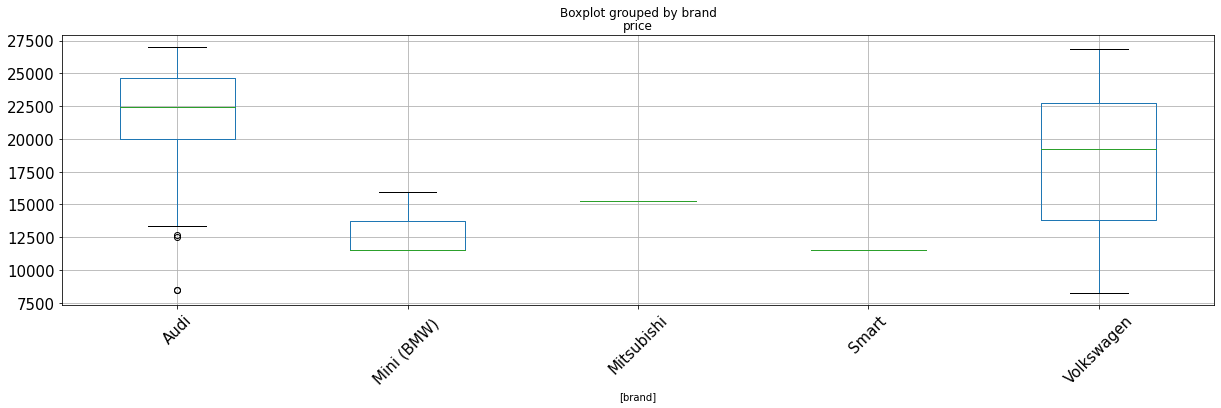

In [40]:
ax = df.boxplot(
        column=['price'],
        by=['brand'],
        figsize=(20,5),
        grid=True,
        rot=45, 
        fontsize=15
)

plt.show()

## VW - Models Price Distributions

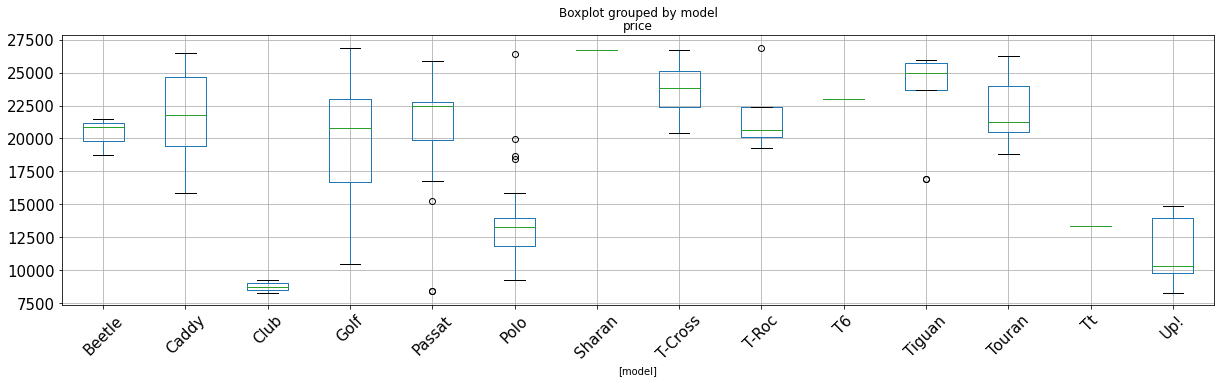

In [39]:
ax = df.query('brand == "Volkswagen"')\
    .boxplot(
        column=['price'],
        by=['model'],
        figsize=(20,5),
        grid=True,
        rot=45, 
        fontsize=15
)

plt.show()

## Find Strongly Correlated Variabels
- remove them to prevent multicollinearity 

In [62]:
df[num_cols].corr().style.format('{:,.0%}').background_gradient(cmap='Blues')

,age,power,engine,motorsize,prevowners,doors,seats,consumption
age,100%,27%,21%,21%,47%,-11%,-9%,3%
power,27%,100%,63%,63%,18%,7%,5%,32%
engine,21%,63%,100%,100%,17%,12%,6%,1%
motorsize,21%,63%,100%,100%,17%,12%,6%,1%
prevowners,47%,18%,17%,17%,100%,-11%,-0%,2%
doors,-11%,7%,12%,12%,-11%,100%,21%,-4%
seats,-9%,5%,6%,6%,-0%,21%,100%,-5%
consumption,3%,32%,1%,1%,2%,-4%,-5%,100%


In [86]:
df[bool_cols].corr()['automatictransmission'].nlargest(n=3)
# .apply(lambda x : x.nlargest(n=1))
# .style.format('{:,.0%}').background_gradient(cmap='Blues')

automatictransmission    1.000000
berganfahrassistent      0.083790
nebelleuchten            0.033759
Name: automatictransmission, dtype: float64

- __engine__ and __motorsize__ are perfectly correlated. And both are strongly correlated with __power__ and in a weaker fashion with __consumption__
- __number of previous owners__ and __vehicle age__ are also strongly correlated

## Run regression

In [92]:
mod = smf.ols(formula='price ~ automatictransmission + age + power + doors + seats + consumption', data=df)
res = mod.fit()
print(res.summary())

OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.661
Model:                            OLS   Adj. R-squared:                  0.658
Method:                 Least Squares   F-statistic:                     243.3
Date:                Fri, 15 May 2020   Prob (F-statistic):          5.12e-172
Time:                        18:27:29   Log-Likelihood:                -7017.9
No. Observations:                 755   AIC:                         1.405e+04
Df Residuals:                     748   BIC:                         1.408e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                      5088.3513  

,age,power,engine,motorsize,prevowners,doors,seats,consumption
age,100%,27%,21%,21%,47%,-11%,-9%,3%
power,27%,100%,63%,63%,18%,7%,5%,32%
engine,21%,63%,100%,100%,17%,12%,6%,1%
motorsize,21%,63%,100%,100%,17%,12%,6%,1%
prevowners,47%,18%,17%,17%,100%,-11%,-0%,2%
doors,-11%,7%,12%,12%,-11%,100%,21%,-4%
seats,-9%,5%,6%,6%,-0%,21%,100%,-5%
consumption,3%,32%,1%,1%,2%,-4%,-5%,100%


array(['automatictransmission', 'guarantee', 'katalysator',
       'parkassistent', 'regenassistent', 'fernlichtassistent',
       'elheckklappe', 'abstandsassistent', 'lendenwirbelsttze', 'mp3',
       'sonnenschutzrollo', 'sitzheizung', 'navigation', 'klimaautomatik',
       'schiebedach', 'drittesitzreihe', 'variablerladeboden',
       'headupdisplay', 'partikelfilter', 'kopfairbag',
       'umklappbarerckksitzbank', 'scheinwerferreinigung',
       'einparkkamery', 'ledscheinwerfer', 'xenon', 'sprachsteuerung',
       'einparkhilfehinten', 'reifendruckkontrolle', 'mittelarmlehne',
       'sportsitze', 'berganfahrassistent', 'telefon', 'komfortschlssel',
       'standheizung', 'spurhalteassistent', 'spurwechselassistent',
       'ledheckleuchten', 'startstopautomatik', 'einparkhilfevorne',
       'servotronic', 'lichtassistent', 'usbschnittstelle',
       'freisprechanlage', 'tagfahrlicht', 'elsitze', 'nebelleuchten',
       'einparkhilfe', 'metalliclackierung', 'sportpaket',
       

todo:
- plot correlation heatmap for exogenous variables
- remove multicolinearity
- check for other biases